# Task 1, solution by D. Uzhva

## Introduction

### Task statement

Implement an approach described in the paper ["Speaker Recognition from Raw Waveform with SincNet"](https://arxiv.org/abs/1808.00158).
Set up experiments and compare the results with those proposed and illustrated in the article.

### Paper review

The paper proposes SincNet CNN architecture
SincNet is a one-dimensional convolutional neural network (CNN) used for speaker recognition.
Compared to a classical 1-D CNN, SincNet differs in its first layer: convolutional kernels are limited to sample values from the reference function 

$$
    g[n, f_1, f_2] = 2 f_2 \text{sinc}(2 \pi f_2 n) - 2 f_1 \text{sinc}(2 \pi f_1 n),
$$ 

where $f_1$ and $f_2$ are so-called cutoff frequencies and [$\text{sinc}$](https://en.wikipedia.org/wiki/Sinc_function) function is defined as

$$
    \text{sinc}(x) = \frac{\sin(x)}{x},
$$ 

thus such layer is called SincConv.
In the frequency domain, $\text{sinc}$ functions represent band-pass filters with the corresponding cutoff frequencies, so that the proposed SincConv layer is believed to extract more meaningful features than filters with arbitrary values.
Indeed, by applying band-pass filtering using $\text{sinc}$ functions one may precisely extract pitch and formants from a sample of speech for further layers to learn such simplified (but at the same time more informative) features.
In other words, band-pass filtering augments the data before the main CNN pipeline.

More than that, by utilizing the described restriction, a SincConv layer would require only $2 F$ parameters to learn (two cutoff frequencies per filter), where $F$ is the number of SincConv filters in a layer.
In comparison, a conventional convolution layer with $F$ filters of length $L$ would require $L \cdot F >> 2 F$ parameters.
With that being said, a SincConv layer may allow to increase overall network performance both during training and evaluation.

### Research questions

In order to verify the approach proposed in the paper, the following research questions are stated.

1. Does a ScinConv layer increases the performance during training and validation?
2. Does a SincConv layer improves accuracy of the CNN in speaker identification?

The improvements are compared to a CNN with a basic first convolution layer.

## Experimental setup

Aiming to reproduce the method proposed in the article, a CNN training pipeline was prepared.
The following packages were used:

* Python 3
* PyTorch
* NumPy
* Pandas
* [SoundFile](https://pypi.org/project/SoundFile/)

The SincConv layer with the network architecture are implemented in [model.py](model.py).
Note that the implementation allows the SincConv layer to accept an input with multiple channels, in contrast to the single-channel version proposed in the [original paper](https://arxiv.org/abs/1808.00158).
A model can be fed to the trainer `train_model()` function in [trainer.py](trainer.py), which also handles dataset split into train and validation parts.
A dataset is loaded by a corresponding loader in [dataloader.py](dataloader.py).
In [main.py](main.py), one can schedule training tasks for various configs defined in [cfg/](cfg/).
Overall pipeline is outlined in [nn_pipeline.pdf](nn_pipeline.pdf):

![](nn_pipeline.png)

### Data preparation

For the series of experiments, the [TIMIT dataset](https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3) is exploited.
This dataset is composed of 6300 spoken sentences stored in .WAV files, which correspond to 630 various speakers (10 sentences per speaker).
The speakers can also be separated by their gender into two classes.
With that being said, [timit_make_labels.py](timit_make_labels.py) allows to prepare a dataframe with label assignments for each sentence.
Two labeling schemes are available: one obtains 630 classes, while the other extracts two gender classes.
In this way, the same TIMIT dataset was used both for binary and multi-class speaker identification tasks.

### CNN architecture and training

Two models were prepared: the former is a standard CNN, and the latter is its copy with the first layer changed to SincConv.
The second network is thus further referred to as SincNet.
In the current series of experiments, the same number of layers and lengths of dense layers as in the article are set.
The only difference of the current architectures comparing to those in the paper is the number of convolution filters: here, only 64, 32 and 32 filters were used for three convolution layers correspondingly for the sake of higher performance.

The SincConv layer implemented in the current setup is in fact generalized to the case of multi-channel input data, in contrast to the layer from the [original paper](https://arxiv.org/abs/1808.00158).
This allows to feed multiple random chunks of a single sentence to SincConv at the same time, increasing accuracy of the SincNet.

Both standard CNN and SincNet were trained for binary and multi-class classification.
Among 6300 sentences in the TIMIT dataset, 80% of them were used in training, while the rest were exploited for validation. 
As in the [original paper](https://arxiv.org/abs/1808.00158), in the current setup RMSprop optimizer was exploited.
The results are provided for 300 epochs and the size of a batch equal to 256.
Initial learning rate was set to 0.001.

## Results

### Performance analysis

A table with the results is provided below, where the numbers represent training time in minutes.

| Network | Multi-class | Binary |
|:------- | -----------:| ------:|
| CNN     | 44.7        | 43.5   |
| SincNet | 38.2        | 37.1   |

It is clear that SincNet is indeed faster than the corresponding CNN.

### Accuracy analysis

Firstly, the log files should be loaded:

In [129]:
import pandas as pd
import os

results_dir = "results/"
log_names = os.listdir(results_dir)

dfs = {}
for name in log_names:
    split = name.split('_')
    n_classes = int(split[3]) # 2 or 630
    cnn_type = split[1] # CNN or SincNet
    if not n_classes in dfs.keys():
        dfs[n_classes] = {} 
    dfs[n_classes][cnn_type] = pd.read_csv(results_dir + name)

epochs = dfs[list(dfs.keys())[0]][list(dfs[list(dfs.keys())[0]].keys())[0]]["epoch"].to_numpy() # epochs

Next, plot the accuracies for binary and multi-class speaker identification results:

In [130]:
import matplotlib.pyplot as plt

def plot_cnn_sincnet(dfs, epoch_ticks, n_classes):
    t_or_v = ["train", "validation"]
    l_or_a = ["loss", "accuracy"]
            
    cnn_color = "#5E81AC"
    sn_color = "#BF616A"
    
    fig, ax = plt.subplots(2, 2, figsize=(9, 4), dpi=200)
    
    for i, loa in enumerate(l_or_a):
        for k, tov in enumerate(t_or_v):
            cnn_data = dfs[n_classes]["CNN"][f"{tov}_{loa}"].to_numpy()
            sn_data = dfs[n_classes]["SincNet"][f"{tov}_{loa}"].to_numpy()
            ax[i, k].plot(epoch_ticks, cnn_data, '--', color=cnn_color, label="CNN")
            ax[i, k].plot(epoch_ticks, sn_data, color=sn_color, label="SincNet")
            ax[i, k].legend()
            if i == len(t_or_v)-1:
                ax[i, k].set_xlabel("epoch")
            if k == 0:
                ax[i, k].set_ylabel(f"{loa}")
            if i == 0:
                ax[i, k].set_title(f"{tov}")
    
    if n_classes > 2:
        classif_task = "multi-class"
    else:
        classif_task = "binary"
    
    fig.suptitle(f"{classif_task}")

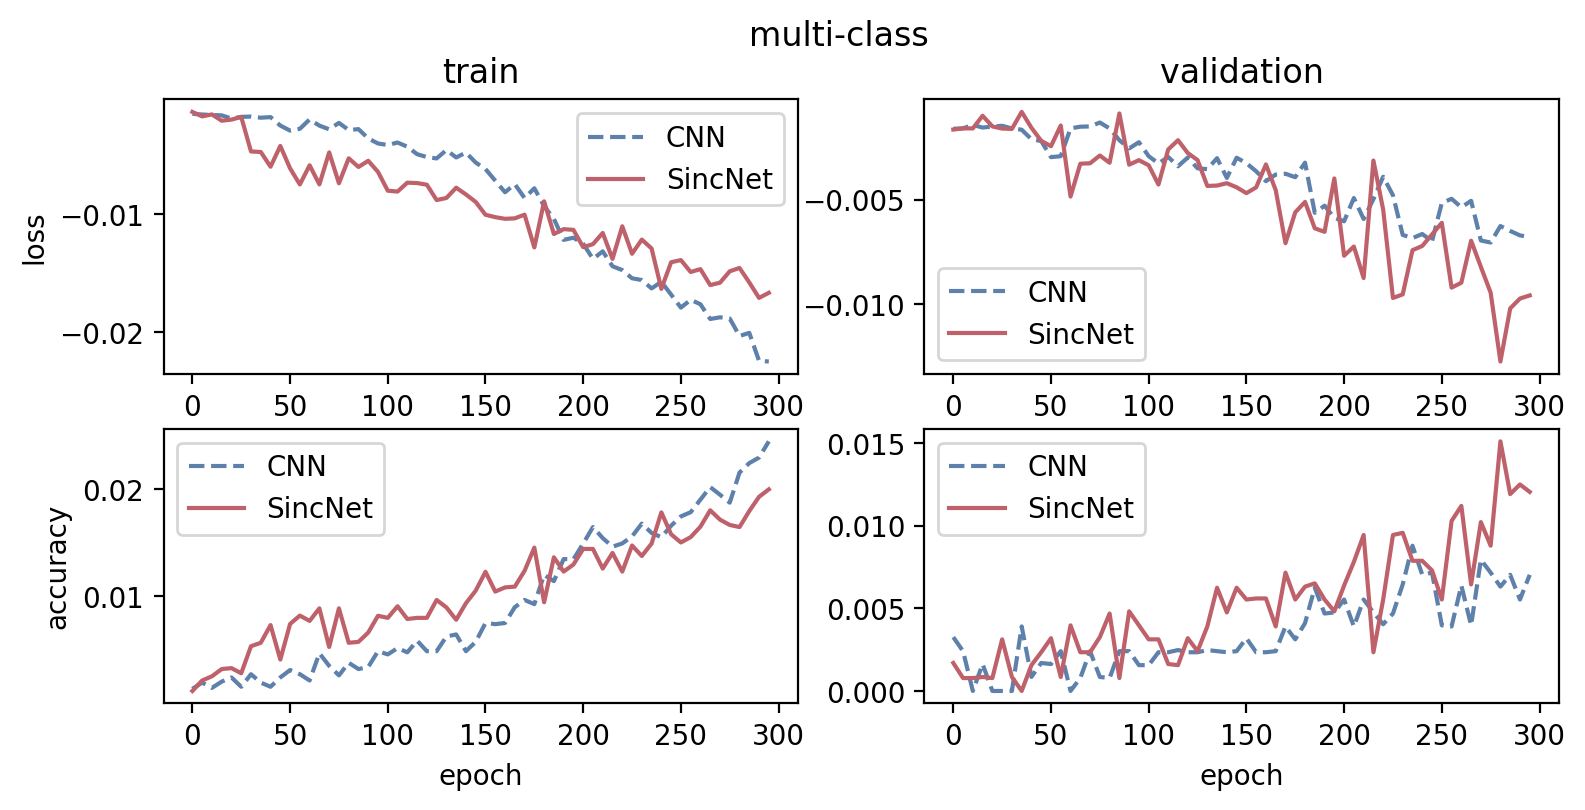

In [131]:
# Multi-class
n_classes = 630
plot_cnn_sincnet(dfs, epochs, n_classes)

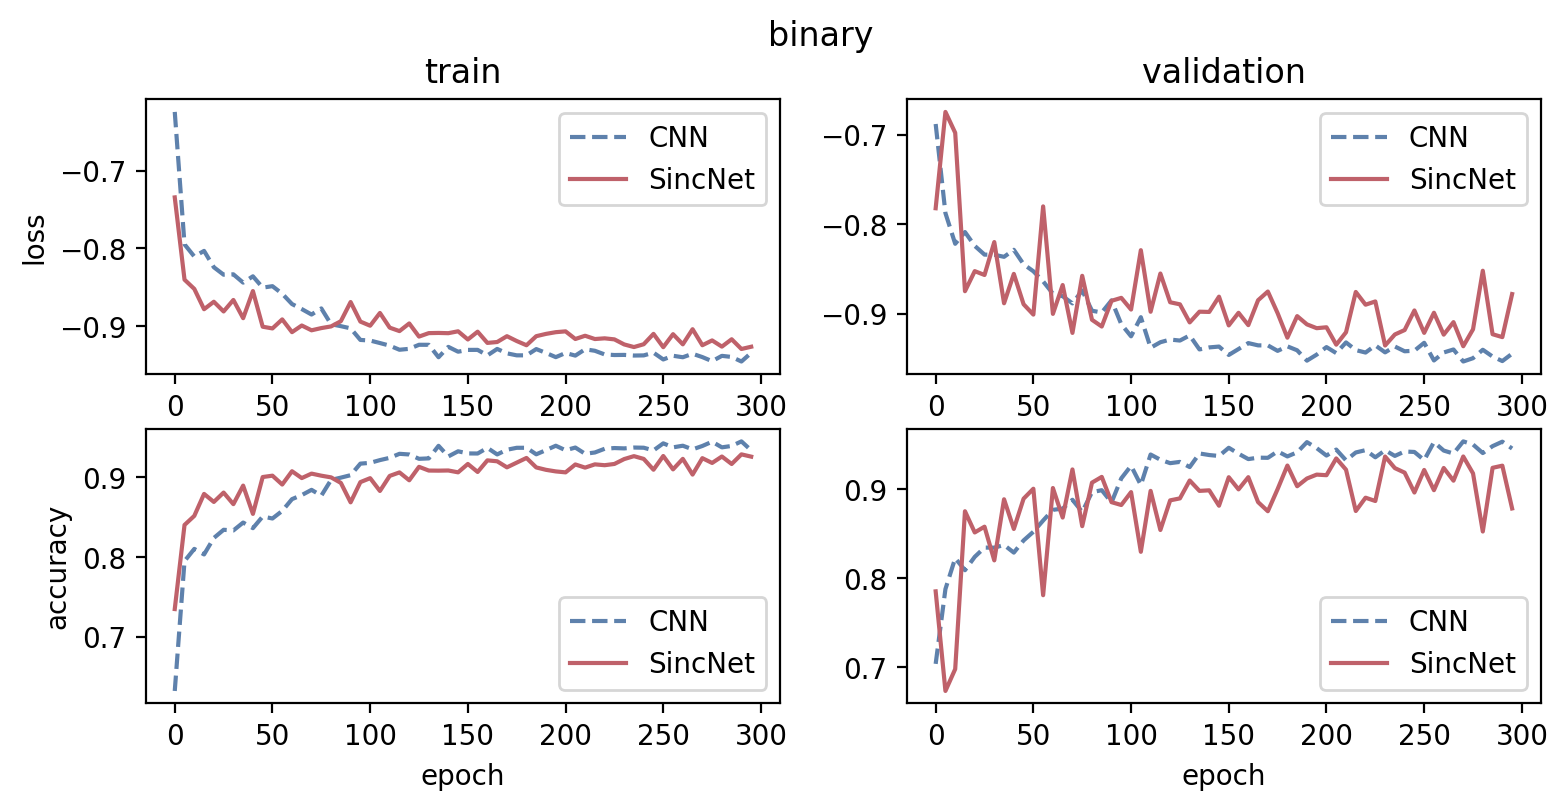

In [132]:
# Binary
n_classes = 2
plot_cnn_sincnet(dfs, epochs, n_classes)

As it is illustrated on the plots, SincNet has the only chance to outperform CNN (in terms of accuracy) in multi-class speaker identification.
However, multi-class experiment might have some issues, which can be seen by how low the accuracy values are (the plot does not reach plateau) even after 300 epochs.
More than that, the plot spikes at certain moments.
The first issue is usually caused by low learning rate, while the second one, on the contrary, often appears due to the learning rate being too high.
With this contradiction being stated, the reasons behind such behaviour require additional thorough research (unit testing, possible data augmentation by removing silences from the sound samples). 

Significantly better results were obtained in the binary classification experiments.
As it was stated in the [original paper](https://arxiv.org/abs/1808.00158), SincNet converges to higher values of accuracy much faster, than a standard CNN.
However, the values of loss and accuracy are getting worse for the SincNet after 80&ndash;90 epoch, comparing to those for the CNN.
Such result does not coincide with one stated in the original paper.
Two possible reasons might cause this mismatch: either the current or the authors' experiment is set up incorrectly, or the authors did not reveal such behaviour of the SincNet after certain epoch in their paper. 
As an example, note that the Frame Error Rate (FER) illustrated on Figure 4 in the paper does not obviously reach plateau, and the CNN FER curve could go below the SincNet FER further.

## Conclusion

With the help of the experiments, it was shown how SincNet can outperform standard CNN.
It was also illustrated in which cases CNN performs better than SincNet.

The obtained results may be used to propose hybrid models, which could accelerate learning process at the start of training by utilizing sinc filters, which are then transfered to standard convolution ones after certain epoch.
In other words, SincNet is trained initially, then it is converted to a standard CNN to obtain a more accurate model.
The following improvements might be considered further for better model performance:

* data augmentation proposed in the original paper (silence removal);
* models with higher number of filters and layers;
* input data in the frequency domain instead of time domain;
* more experiments with multi-channel inputs;
* hybrid models.